# 01. Load image and depth map

In [1]:
import open3d as o3d
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial import KDTree

# read grayscale image
# Load the RGB image
rgb_image = cv2.imread("im0.png")  # Reads as BGR
### CUBE RESIZED EXAMPLE ###
DIR = "../dataset/"
color_path = f"{DIR}cube_resized.jpg"
depth_path = f"{DIR}cube_resized_depth_map.png"

color_raw = o3d.io.read_image(color_path)
depth_raw = o3d.io.read_image(depth_path)


rbgd = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, depth_raw, convert_rgb_to_intensity=False
)

print(rbgd)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
RGBDImage of size 
Color image : 548x548, with 3 channels.
Depth image : 548x548, with 1 channels.
Use numpy.asarray to access buffer data.


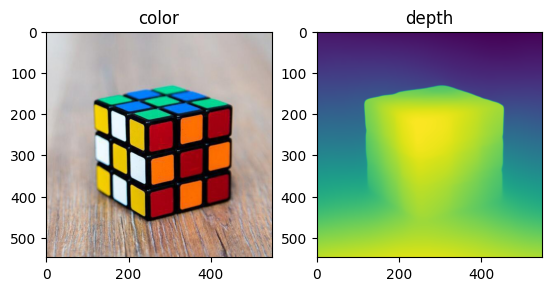

In [17]:
# Display pictures
plt.subplot(1, 2, 1)
plt.title('color')
plt.imshow(color_raw)
plt.subplot(1, 2, 2)
plt.title('depth')
plt.imshow(depth_raw)
plt.show()

# 02. Set up camera

In [18]:
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(
    o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault
)

# 03. Create a pointcloud

In [19]:
# pcd, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rbgd, camera_intrinsic
)

pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])


o3d.visualization.draw_geometries([pcd])

# 04. Choose only points with certain density inside the voxel

In [20]:
voxel_size = 0.00001  # Adjust this value based on your data

# Compute voxel grid
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd, voxel_size)
voxels = voxel_grid.get_voxels()
print(len(voxels))
#o3d.visualization.draw_geometries([voxel_grid])

# Create a mapping from grid index to point count
voxel_dict = {}
point_indices = np.floor(np.asarray(pcd.points) / voxel_size).astype(int)

for index in point_indices:
    voxel_index = tuple(index)
    voxel_dict[voxel_index] = voxel_dict.get(voxel_index, 0) + 1

# Define density threshold
min_points_per_voxel = 10  # Adjust as needed

# Filter points based on voxel density
filtered_points = [
    p for i, p in enumerate(np.asarray(pcd.points))
    if voxel_dict.get(tuple(point_indices[i]), 0) >= min_points_per_voxel
]

# Create new filtered point cloud
filtered_pcd = o3d.geometry.PointCloud()
filtered_pcd.points = o3d.utility.Vector3dVector(filtered_points)

# Visualize the filtered point cloud
#o3d.visualization.draw_geometries([filtered_pcd])

12254


# 05. Downsample

In [21]:
# Downsample and get keypoints
voxel_size = 0.0001 # Size of the boundarying box
pcd_down = filtered_pcd.voxel_down_sample(voxel_size=voxel_size)

# Visualize the downsampled point cloud
#o3d.visualization.draw_geometries([pcd_down])

print("Number of points after downsampling: ", len(pcd_down.points))

Number of points after downsampling:  158


# 06. Segmentation task

In [22]:
# Segment the largest plane using RANSAC
plane_model, inliers = pcd_down.segment_plane(
                                         distance_threshold=0.0001,
                                         ransac_n=10,
                                         num_iterations=1000)

# Extract plane and non-plane points
plane = pcd_down.select_by_index(inliers)
plane.paint_uniform_color([1, 0, 0])  # Color plane red
non_plane = pcd_down.select_by_index(inliers, invert=True)

# Visualize
#o3d.visualization.draw_geometries([non_plane])

print("Number of points after plane segmentation: ", len(non_plane.points))


Number of points after plane segmentation:  57


# 06.b Delete the bulb of points distant from the main bulb of points

Apply clustering and keep bigger bulb of points

In [23]:

# Convert point cloud to numpy array
points = np.asarray(non_plane.points)

# Define the number of clusters
num_clusters = 2  # Adjust this value based on your needs

# Perform K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, max_iter=100000, init='k-means++', n_init=10).fit(points)
labels = kmeans.labels_

# Assign colors to each cluster
colors = np.random.rand(num_clusters, 3)
non_plane.colors = o3d.utility.Vector3dVector(colors[labels])


# Identify the larger cluster
unique, counts = np.unique(labels, return_counts=True)
larger_cluster_label = unique[np.argmax(counts)]

# Select points that belong to the larger cluster
larger_cluster_indices = np.where(labels == larger_cluster_label)[0]
larger_cluster = non_plane.select_by_index(larger_cluster_indices)

# Visualize the larger cluster
o3d.visualization.draw_geometries([larger_cluster], height=800, width=800)

c:\Users\ewa.miazga\miniconda3\envs\open3d_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


# 06.c Take points that are at certain distance to non plane points

In [24]:
cube = larger_cluster

# Convert point clouds to numpy arrays
pcd_points = np.asarray(pcd.points)
cube_points = np.asarray(cube.points)

# Build a KDTree using the original point cloud
kdtree = KDTree(pcd_points)

# Define the distance threshold
distance_threshold = 0.0001  # Adjust this value as needed

# Find points within the distance threshold from the non-plane points
indices = kdtree.query_ball_point(cube_points, r=distance_threshold)

# Flatten the list of indices and remove duplicates
indices = np.unique(np.concatenate(indices)).astype(int).tolist()

# Select the filtered points from the original point cloud
filtered_pcd = pcd.select_by_index(indices)

# Delete outliers
#filtered_pcd, ind = filtered_pcd.remove_statistical_outlier(nb_neighbors=100000, std_ratio=12.0)

# Visualize the filtered points
o3d.visualization.draw_geometries([filtered_pcd], height=800, width=800)

# 07. Estimate Normals

In [25]:
filtered_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Visualize
#o3d.visualization.draw_geometries([filtered_pcd], 
#                                   point_show_normal=True,
#                                   mesh_show_wireframe=True, 
#                                   mesh_show_back_face=True
#                                   )

In [26]:
print(f"Number of points in cube: {len(filtered_pcd.points)}")

Number of points in cube: 90777


# 08. Estimate full convex hull 

In [27]:
hull, _ = filtered_pcd.compute_convex_hull()
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
hull_ls.paint_uniform_color([1, 0, 0])
o3d.visualization.draw_geometries([filtered_pcd, hull_ls])

# 09.b Extract edges

In [30]:
# Visualize filtered point cloud
# Ensure normals are oriented consistently
filtered_pcd.orient_normals_consistent_tangent_plane(100)
#o3d.visualization.draw_geometries([filtered_pcd], height=800, width=800)
voxel_size = 0.00001  # Adjust this value based on your data

def calculate_angle_between_normals(normal1, normal2):
    """Calculate the angle between two normals in degrees."""
    dot_product = np.dot(normal1, normal2)
    dot_product = np.clip(dot_product, -1.0, 1.0)  # Clip to the range [-1, 1]
    angle = np.arccos(dot_product) * (180.0 / np.pi)
    return angle

# Convert points and normals to numpy arrays
points = np.asarray(filtered_pcd.points)
normals = np.asarray(filtered_pcd.normals)

# KDTree for neighbor search
kdtree = o3d.geometry.KDTreeFlann(filtered_pcd)

# Define the angle threshold
angle_threshold = 45.0  # in degrees

# List to store indices of points to keep
indices_to_keep = []

# Iterate over all points
for i in range(len(points)):
    [_, idx, _] = kdtree.search_radius_vector_3d(filtered_pcd.points[i], voxel_size * 2)
    keep_point = False
    for j in idx:
        if i != j:
            angle = calculate_angle_between_normals(normals[i], normals[j])
            if angle > angle_threshold:
                keep_point = True
                break
    if keep_point:
        indices_to_keep.append(i)

# Select the filtered points
filtered_points = filtered_pcd.select_by_index(indices_to_keep)

# Visualize the filtered points
o3d.visualization.draw_geometries([filtered_points], height=800, width=800)

# 10.a Try create a convex hull



In [45]:
# Downsample 
voxel_size = 0.0001 #0.0005  # Adjust this value based on your data
filtered_points_down = filtered_points.voxel_down_sample(voxel_size=voxel_size)



hull, _ = filtered_points_down.compute_convex_hull()
hull_ls = o3d.geometry.LineSet.create_from_triangle_mesh(hull)
hull_ls.paint_uniform_color([1, 0, 0])
o3d.visualization.draw_geometries([filtered_points_down, hull_ls])

# 11. Apply modified (from 2D->3D) algorithm

In [78]:

class PointCloudProcessor:
    def __init__(self, point_cloud):
        assert isinstance(point_cloud, o3d.geometry.PointCloud), "Input must be an Open3D PointCloud object"
        
        self.pcd = point_cloud
        self.corner_infos = self.process_point_cloud()
        self.contour_edges = []
        
    def process_point_cloud(self):
        # Compute convex hull (alternative to contours in 3D)
        hull, _ = self.pcd.compute_convex_hull()
        hull_points = np.asarray(hull.vertices)
        
        return hull_points

    def compute_contour_edges(self):
        nodes_per_contour = []  # List of lists, each list contains nodes of a contour
        contour_edges = []

        # Convert corner_infos to a NumPy array
        corner_infos_array = np.asarray(self.corner_infos)
        print(corner_infos_array.shape)
        
        num_corners = corner_infos_array.shape[0]
        
        contour_nodes = []
        for index in range(num_corners):
            node_pos = corner_infos_array[index]
            print(f"Node_pos: {node_pos}")
            
            prev_pos = corner_infos_array[(index - 1) % num_corners]
            next_pos = corner_infos_array[(index + 1) % num_corners]
            
            # Compute gradients for contour edges
            x_grad_pre = None if prev_pos[1] == node_pos[1] else 'xneg' if prev_pos[1] < node_pos[1] else 'xpos'
            y_grad_pre = None if prev_pos[0] == node_pos[0] else 'yneg' if prev_pos[0] > node_pos[0] else 'ypos'
            grads_pre = {'x': x_grad_pre, 'y': y_grad_pre}
            
            node = f"node_{index}"
            if contour_nodes:
                contour_edges.append((node, contour_nodes[-1], grads_pre))
            
            if index == num_corners - 1 and num_corners > 1:
                x_grad_post = None if node_pos[1] == next_pos[1] else 'xneg' if node_pos[1] < next_pos[1] else 'xpos'
                y_grad_post = None if node_pos[0] == next_pos[0] else 'yneg' if node_pos[0] > next_pos[0] else 'ypos'
                grads_post = {'x': x_grad_post, 'y': y_grad_post}
                contour_edges.append((contour_nodes[0], node, grads_post))
            
            contour_nodes.append(node)
        nodes_per_contour.append(contour_nodes)
        
        return nodes_per_contour, contour_edges
    

    def visualize_contour_edges(self, nodes_per_contour, contour_edges):
        # Create a LineSet for visualization
        lines = []
        line_colors = []
        for edge in contour_edges:
            node1, node2, _ = edge
            index1 = int(node1.split('_')[-1])
            index2 = int(node2.split('_')[-1])
            lines.append([index1, index2])
            line_colors.append([1, 0, 0])  # Red color for edges

        line_set = o3d.geometry.LineSet()
        line_set.points = o3d.utility.Vector3dVector(self.corner_infos)
        line_set.lines = o3d.utility.Vector2iVector(lines)
        line_set.colors = o3d.utility.Vector3dVector(line_colors)

        # Visualize the point cloud and the contour edges
        o3d.visualization.draw_geometries([self.pcd, line_set], height=800, width=800)
    
# Example usage:
#pcd = o3d.io.read_point_cloud("point_cloud.ply")
pcd = filtered_points_down
processor = PointCloudProcessor(pcd)
nodes, edges = processor.compute_contour_edges()
print(nodes, edges)


(35, 3)
Node_pos: [ 0.00017447  0.00010564 -0.00086117]
Node_pos: [ 0.00016896 -0.00016492 -0.00071981]
Node_pos: [ 1.99628428e-04  2.19104830e-05 -8.37959145e-04]
Node_pos: [-0.0001648  -0.00031372 -0.00082234]
Node_pos: [-1.77263104e-05 -3.24240859e-04 -8.33907241e-04]
Node_pos: [-0.00015363 -0.00032489 -0.00083431]
Node_pos: [-2.88468133e-04 -4.59127332e-06 -7.74012285e-04]
Node_pos: [-2.96417014e-04  5.13271320e-05 -7.98977663e-04]
Node_pos: [-1.60352325e-04 -4.08494667e-05 -9.80827925e-04]
Node_pos: [ 1.92133472e-04 -2.47155214e-05 -8.15256192e-04]
Node_pos: [-0.00012075 -0.00031982 -0.00086671]
Node_pos: [-2.71618789e-04  8.90331871e-05 -8.71177604e-04]
Node_pos: [-0.00028612  0.00011267 -0.00082581]
Node_pos: [-5.23809535e-05  1.43873019e-04 -7.33333349e-04]
Node_pos: [ 1.83103492e-04  7.78756938e-05 -8.66306025e-04]
Node_pos: [-3.14560494e-05 -6.90241438e-05 -9.61624660e-04]
Node_pos: [ 4.26606917e-05  6.18218498e-05 -9.49019624e-04]
Node_pos: [ 3.22632178e-05 -2.92178750e-04 -

In [79]:
processor.visualize_contour_edges(nodes, edges)